## Mitochondria Segmentation with a simple U-Net

#### Imports

In [9]:
import simple_model
import os
import cv2
import pandas as pd
from skimage import io
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from private_path import train_image_path, train_mask_path, test_image_path, test_mask_path
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import normalize
from keras.models import load_model
from loses_and_metrics import dice_coefficient, dice_coefficients_loss, iou
from utils import createImageSegmentationGenerator


#### Load data

In [10]:
train_images = io.imread(train_image_path)
train_masks = io.imread(train_mask_path)
test_images = io.imread(test_image_path)
test_masks = io.imread(test_mask_path)
print(f'Train Image Shape: {train_images.shape}')
print(f'Train mask Shape: {train_masks.shape}')
print(f'Test images Shape: {test_images.shape}')
print(f'Test mask Shape: {test_masks.shape}')

Train Image Shape: (165, 768, 1024)
Train mask Shape: (165, 768, 1024)
Test images Shape: (165, 768, 1024)
Test mask Shape: (165, 768, 1024)


#### Resize and reshape dimensions for training/testing

In [11]:
# Data preprocessing 
SIZE = 256
# Reshape train images and convert to numpy array
X_train = []
for image in train_images:
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        X_train.append(image)
# Reshape train masks and convert to numpy array
y_train = []
for mask in train_masks:
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask = np.array(mask)
        y_train.append(mask)
# Refactor 100 test images/masks to train images/masks to have 280 - 35 - 15 train-test-val split
X_test = []
for image in test_images:
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        X_test.append(image)
y_test = []
for mask in test_masks:
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask = np.array(mask)
        y_test.append(mask)
# Append to train images in masks
for image in X_test[:115]:
        X_train.append(image)
for mask in y_test[:115]:
        y_train.append(mask)
# Add 15 Images for validation
X_val = [image for image in X_test[115:130]]
y_val = [mask for mask in y_test[115:130]]

# Rest of the images for testing 
X_test = X_test[130:]
y_test = y_test[130:]

# Normalize images and expand dims
X_train = np.expand_dims(np.array(X_train), 3) 
X_val = np.expand_dims(np.array(X_val), 3) 
X_test = np.expand_dims(np.array(X_test), 3)
# Rescale masks from 0 to 1 and expand dims
y_train = np.expand_dims((np.array(y_train)),3) 
y_val = np.expand_dims((np.array(y_val)),3) 
y_test = np.expand_dims((np.array(y_test)),3) 

print(f'Train Image Shape: {X_train.shape}')
print(f'Train mask Shape: {y_train.shape}')
print(f'val Image Shape: {X_val.shape}')
print(f'val mask Shape: {y_val.shape}')
print(f'Test images Shape: {X_test.shape}')
print(f'Test mask Shape: {y_test.shape}')

Train Image Shape: (280, 256, 256, 1)
Train mask Shape: (280, 256, 256, 1)
val Image Shape: (15, 256, 256, 1)
val mask Shape: (15, 256, 256, 1)
Test images Shape: (35, 256, 256, 1)
Test mask Shape: (35, 256, 256, 1)


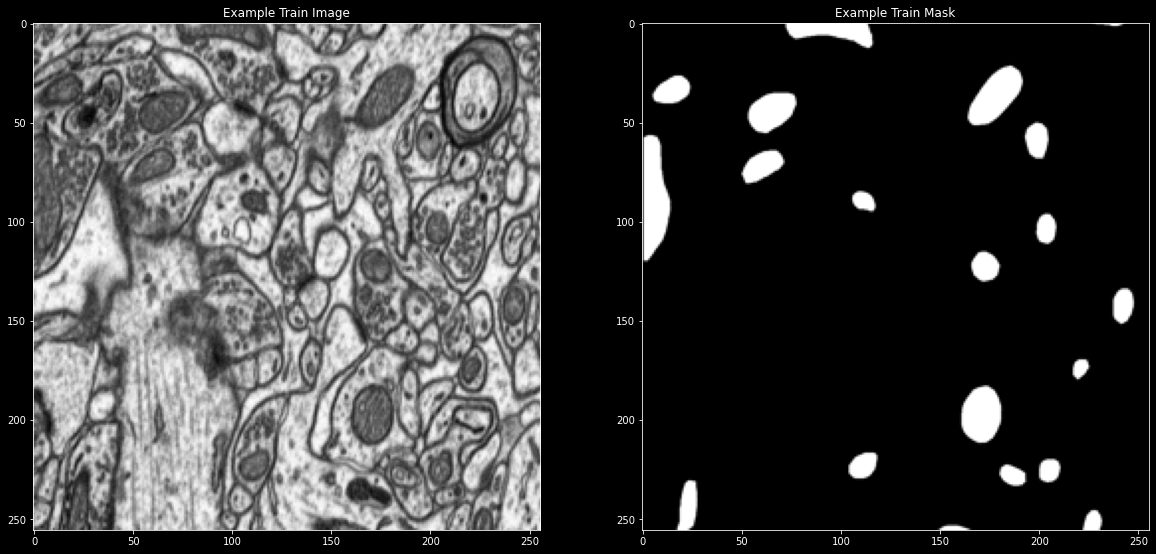

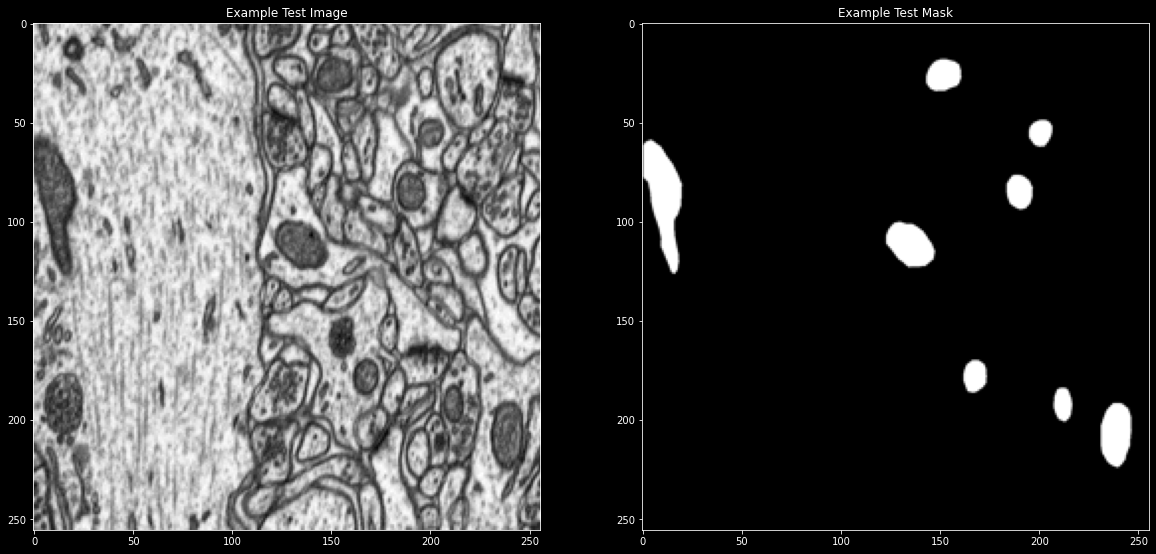

In [12]:
# Sanity check 
plt.figure(figsize=(20,15))
plt.axis('off')
plt.subplot(121)
plt.title('Example Train Image')
plt.imshow(X_train[200], cmap='gray')
plt.subplot(122)
plt.title('Example Train Mask')
plt.imshow(y_train[200], cmap='gray')
# Sanity check 
plt.figure(figsize=(20,15))
plt.axis('off')
plt.subplot(121)
plt.title('Example Test Image')
plt.imshow(X_test[20], cmap='gray')
plt.subplot(122)
plt.title('Example Test Mask')
plt.imshow(y_test[20], cmap='gray')


#### Create Train- and Test Generators 

In [13]:
# Hyperparameters
BATCH_SIZE = 30
EPOCHS = 20
learning_rate = 1e-4
decay_rate = learning_rate/EPOCHS
steps_per_epoch = len(test_images) / BATCH_SIZE

# Create image generators with augmentation 
train_gen = createImageSegmentationGenerator(images=X_train, masks=y_train, batch_size=BATCH_SIZE)
test_gen = createImageSegmentationGenerator(images = X_test,masks= y_test, batch_size=BATCH_SIZE)

'# Hyperparameters\nBATCH_SIZE = 30\nEPOCHS = 20\nlearning_rate = 1e-4\ndecay_rate = learning_rate/EPOCHS\nsteps_per_epoch = len(test_images) / BATCH_SIZE\n\n# Create image generators with augmentation \ntrain_gen = createImageSegmentationGenerator(images=X_train, masks=y_train, batch_size=BATCH_SIZE)\ntest_gen = createImageSegmentationGenerator(images = X_test,masks= y_test, batch_size=BATCH_SIZE)'

#### Load and Train Model

In [14]:
# Load model with input size 256x256x1 color channels for grayscale
model = simple_model.Unet(input_size=(SIZE,SIZE,1))
# Load optimizer 
optimizer = Adam(learning_rate=learning_rate, amsgrad=False)
# Compile Model
model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=['binary_accuracy', iou, dice_coefficient])
# Defince training callback
callback = [ModelCheckpoint('mitochondriaSegmentationUNet.hdf5', verbose=1, save_best_only=True)]

"# Load model with input size 256x256x1 color channels for grayscale\nmodel = simple_model.Unet(input_size=(SIZE,SIZE,1))\n# Load optimizer \noptimizer = Adam(learning_rate=learning_rate, amsgrad=False)\n# Compile Model\nmodel.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=['binary_accuracy', iou, dice_coefficient])\n# Defince training callback\ncallback = [ModelCheckpoint('mitochondriaSegmentationUNet.hdf5', verbose=1, save_best_only=True)]"

In [15]:
# Start training! - slow in ipynb :'|  
history = model.fit(
                train_gen,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                steps_per_epoch=steps_per_epoch,
                callbacks=callback,
                validation_data=test_gen,
                validation_steps=len(X_test)/ BATCH_SIZE
                )

'history = model.fit(\n                train_gen,\n                batch_size=BATCH_SIZE,\n                epochs=EPOCHS,\n                steps_per_epoch=steps_per_epoch,\n                callbacks=callback,\n                validation_data=test_gen,\n                validation_steps=len(X_test)/ BATCH_SIZE\n                )'

#### Load trained Model

In [16]:
eval_model = load_model('mitochondriaSegmentationUNet.hdf5', custom_objects={'dice_coefficients_loss':dice_coefficients_loss, 'iou': iou, "dice_coefficient":dice_coefficient })

In [17]:
# Test Model!
val_gen = createImageSegmentationGenerator(X_val, y_val, batch_size=1)
results = eval_model.evaluate(val_gen, steps=len(X_test)/1)
print(f'Test Dice Loss: {results[0]}\n'
      f'Test Intersection over Union: {results[1]}\n'
      f'Test Dice Coeff: {results[2]}')

35/35 [==============================] - 4s 13ms/step - loss: -0.9205 - binary_accuracy: 0.9944 - iou: 0.8554 - dice_coefficient: 0.9205
Test Dice Loss: -0.9204916954040527
Test Intersection over Union: 0.9944039583206177
Test Dice Coeff: 0.8554201722145081


1/1 [==============================] - 0s 21ms/step


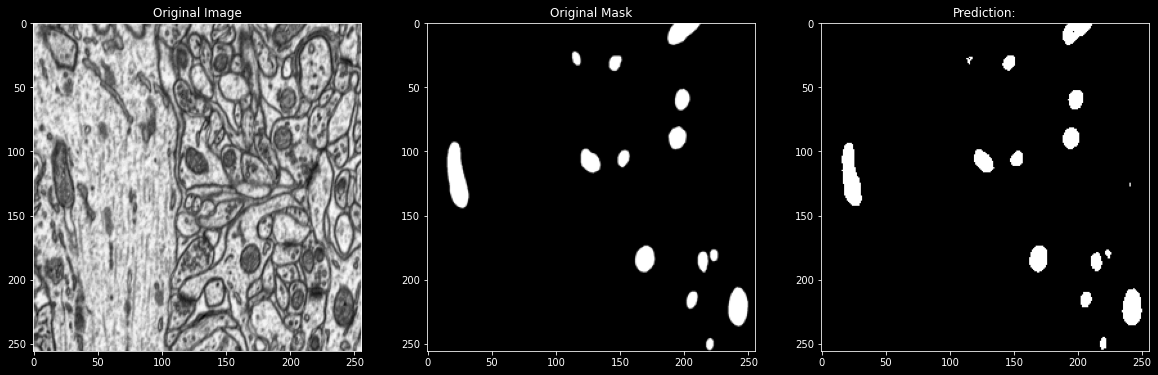

1/1 [==============================] - 0s 20ms/step


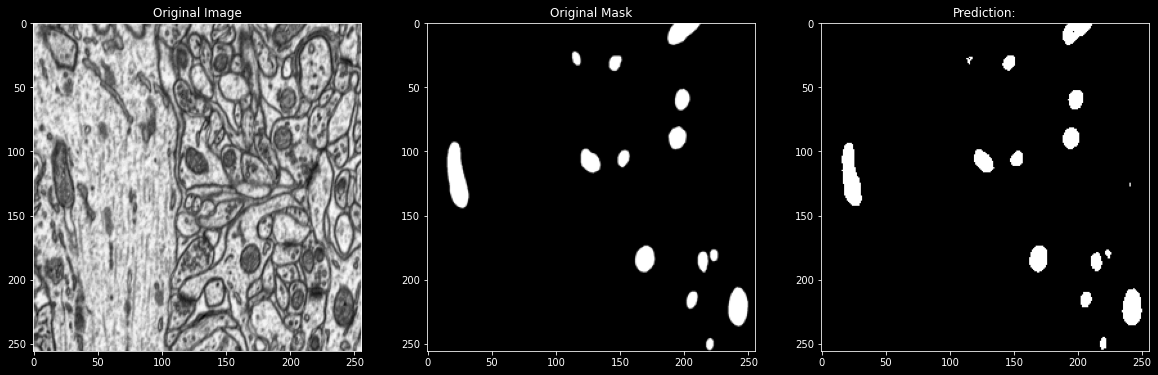

1/1 [==============================] - 0s 21ms/step


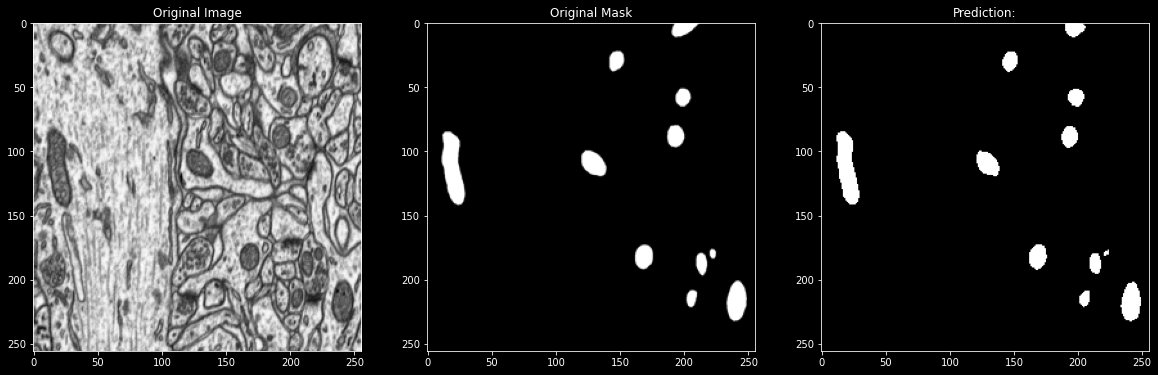

1/1 [==============================] - 0s 20ms/step


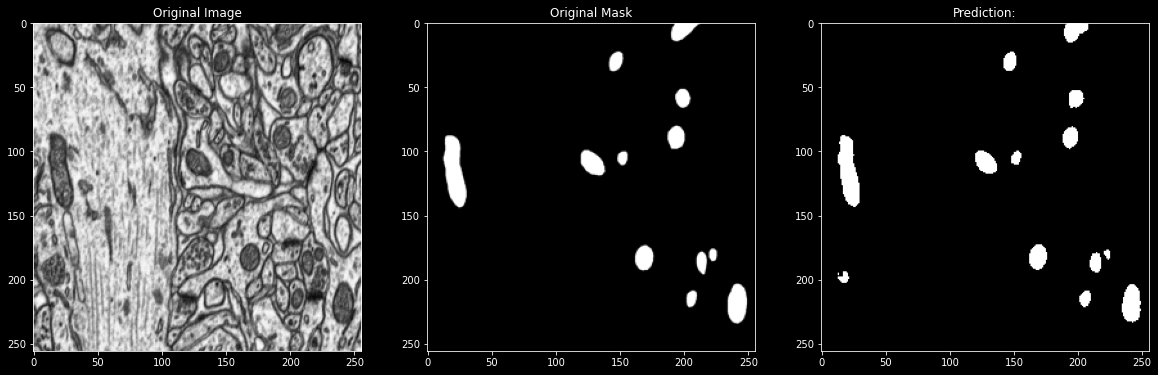

1/1 [==============================] - 0s 29ms/step


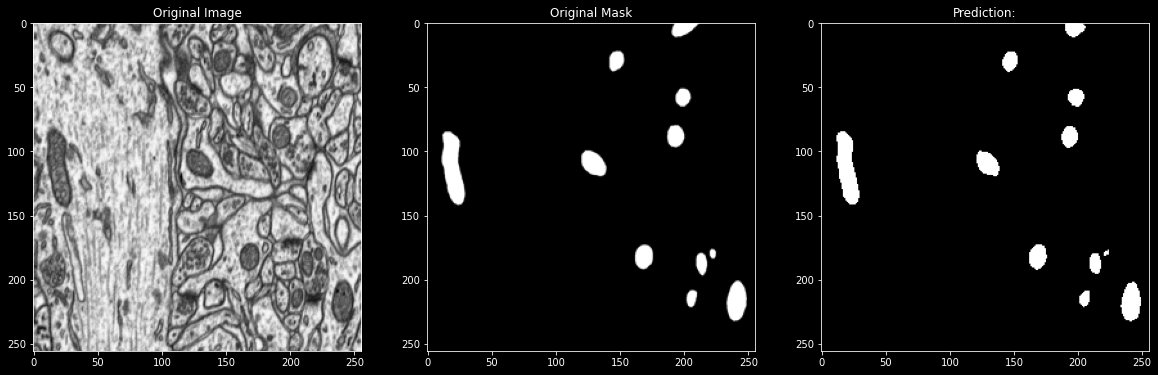

1/1 [==============================] - 0s 19ms/step


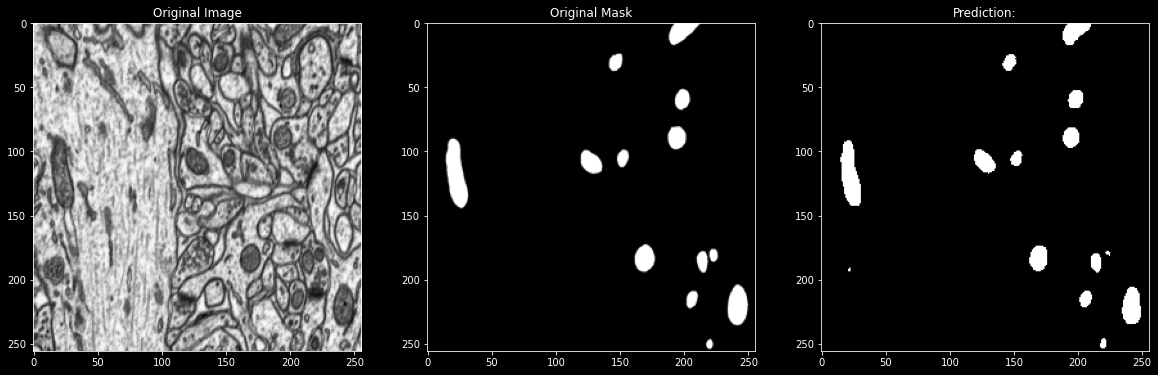

1/1 [==============================] - 0s 19ms/step


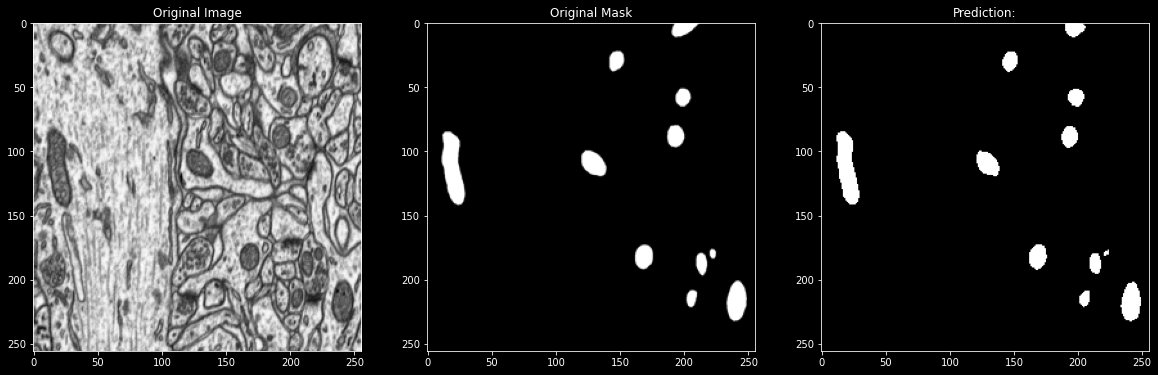

1/1 [==============================] - 0s 24ms/step


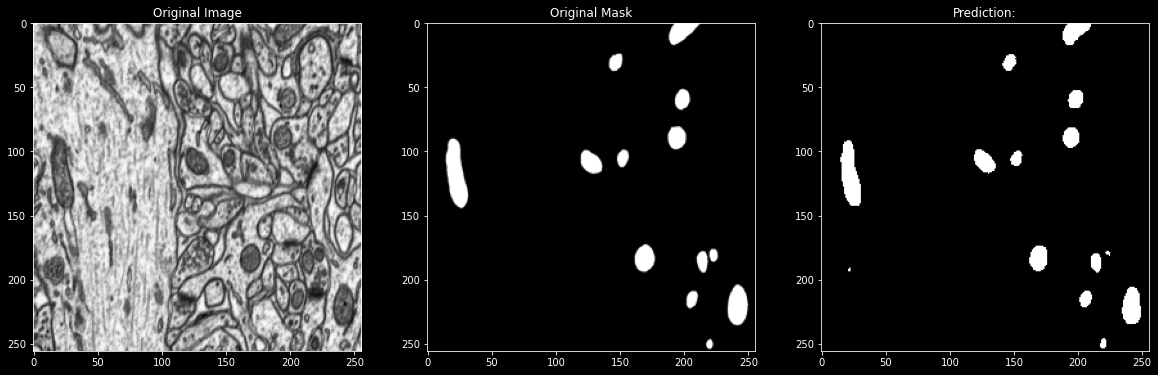

1/1 [==============================] - 0s 19ms/step


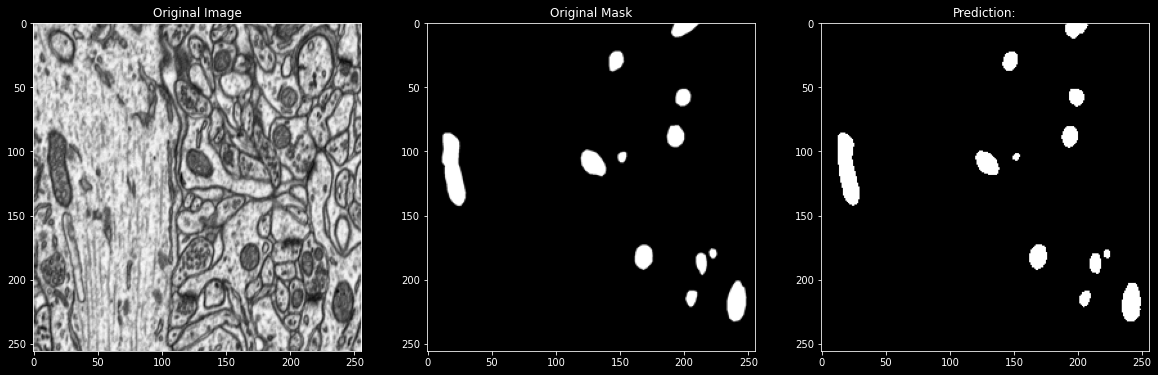

1/1 [==============================] - 0s 18ms/step


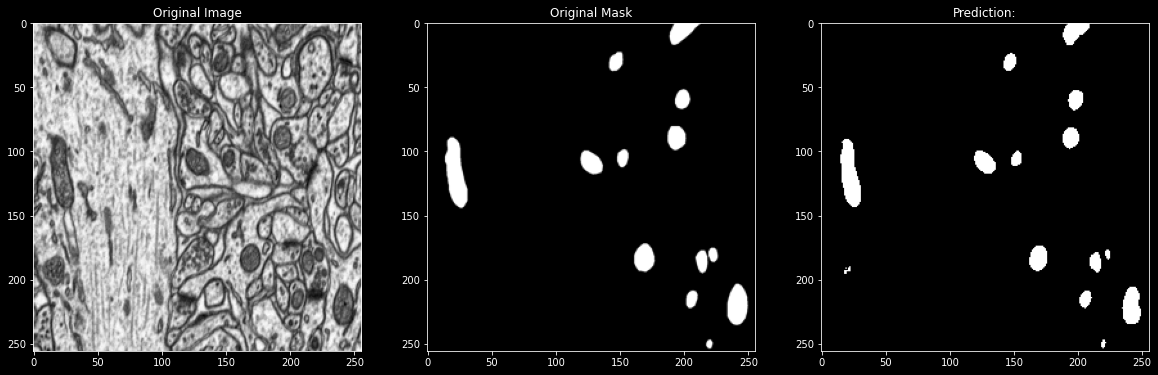

In [20]:
for i in range(10):
        index = np.random.randint(1, len(X_val))
        img = X_val[index] /255
        img = img[np.newaxis, :, :, : ]
        predicted_img = eval_model.predict(img)
        
        plt.figure(figsize=(20, 15))
        plt.style.use('dark_background')
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[index,:,:,:], cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(y_val[index], cmap='gray')
        plt.title('Original Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(predicted_img) >0.6, cmap='gray')
        plt.title('Prediction:')
        plt.show()